# Contents

This notebook deals with the data analysis of chemostat experiments with wild type _Lactococcus lactis_ MG1363 and a CcpA mutant 445C1. It consist of the protoeme analysis and the analysis of metabolic fluxes, among which amino acid fluxes. 

1. [Imports and create variables](#section1)
2. [Import data](#section2)
3. [Mappers uniprotID to locus tag](#mappers)
4. [Data selection](#data_selection)
4.1 [Statistics and interesting proteins](#statistics)
4.2 [iBAQs](#iBAQ)
5. [Volcano plots](#volcano_plots)
6. [Exchange fluxes](#flux)
7. [Principal Component analysis](#pca)


<a id='section1'></a>    

## 1. Imports and create variables


In [1]:
import cbmpy as cbm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import numpy as np

import scipy
import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
import os

%matplotlib inline 
%load_ext autoreload
%autoreload 2




CPLEX 12.9.0.0 is not compatible with this version of Python.



CPLEX not available

*****
Using GLPK
*****


CBMPy environment
******************
Revision: r689


***********************************************************************
* Welcome to CBMPy (0.7.25) - PySCeS Constraint Based Modelling       *
*                http://cbmpy.sourceforge.net                         *
* Copyright(C) Brett G. Olivier 2014 - 2019                           *
* Dept. of Systems Bioinformatics                                     *
* Vrije Universiteit Amsterdam, Amsterdam, The Netherlands            *
* CBMPy is developed as part of the BeBasic MetaToolKit Project       *
* Distributed under the GNU GPL v 3.0 licence, see                    *
* LICENCE (supplied with this release) for details                    *
***********************************************************************



ImportError: No module named sklearn.decomposition

In [ ]:
matplotlib.font_manager._rebuild()

In [ ]:
# set font to Helvetica
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [ ]:
# set font to Helvetica for seaborn
sns.set(font='sans-serif', rc=sns._orig_rc_params)

In [ ]:
# To show minus sign (-) with seaborn
rcParams['axes.unicode_minus']=False

In [ ]:
# Set workbookDir
workbookDir = os.getcwd()

In [ ]:
# Import model
input_model = 'MG1363_20190628.xml'
sbml_model = os.path.join('models', input_model)
cmod = cbm.readSBML3FBC(sbml_model)

# Fetch the dictionary containing all gene-protein associations
reacgenasc = cmod.getAllGeneProteinAssociations()
genreacasc = cmod.getAllProteinGeneAssociations()

<a id='section2'></a>

## 2. Import data

In this part the dataframe is loaded and indexed

#### Proteome data

In [ ]:
preprocessed_data = pd.read_csv(os.path.join(workbookDir, "data", "CcpA_chemostat", "20191014_perseusprocessed.txt"), 
                                sep='\t',
                                na_filter = False)
preprocessed_data.head()

In [ ]:
# Filter first rows
preprocessed_data.drop([0,1],axis=0, inplace=True)
preprocessed_data.head()

In [ ]:
# Set index
preprocessed_data.set_index('Majority protein IDs', inplace=True)
preprocessed_data.head()

In [ ]:
# put info first gene
preprocessed_data["Gene names  (ordered locus )"]["A2RH74"]="llmg_0001"
preprocessed_data["Mass"]["A2RH74"]="51,317"

In [ ]:
# Rename very long Majority protein ID which is not in annotations to shorter one
preprocessed_data.rename(index={'A2RJ63_LACLMDNA-invertase/resolvaseOS=Lactococcuslactissubsp.cremoris(strainMG1363)GN=tnpRPE=4SV=1^Atr;A0A1B1H1X6':'A2RJ63'},inplace=True)
preprocessed_data.loc['A2RJ63']

In [ ]:
# Remove these non-lactis proteins:
preprocessed_data.drop(
    ['CON__sp|P00760|TRY1_BOVIN', 'CON__sp|P04264|K2C1_HUMAN', 'CON__sp|P35527|K1C9_HUMAN', 'CON__sp|P35908|K22E_HUMAN'],
    axis=0, inplace=True)


In [ ]:
preprocessed_data['Mass'] = preprocessed_data['Mass'].str.replace(',','.')
preprocessed_data['Mass']

In [ ]:
# Convert mass to float. Take average if two masses noted, because of two locus tags
for i in preprocessed_data[pd.to_numeric(preprocessed_data['Mass'], errors='coerce').isnull()==True]["Mass"].index:
    print i
    print preprocessed_data["Mass"][i].split(";")
    a = [float(j) for j in preprocessed_data["Mass"][i].split(";")]
    preprocessed_data["Mass"][i] = sum(a)/len(a)
    
preprocessed_data["Mass"] = pd.to_numeric(preprocessed_data['Mass'], errors='coerce')

In [ ]:
# Load unimputed LFQ data
LFQ_data = pd.read_csv(os.path.join(workbookDir, "data", "CcpA_chemostat", "20200921_perseus_notimputedLFQ.txt"), 
                                sep='\t',
                                na_filter = False)
# Filter first rows
LFQ_data.drop([0,1],axis=0, inplace=True)

# Set index
LFQ_data.set_index('Majority protein IDs', inplace=True)
LFQ_data.head()

# Put info first gene
LFQ_data["Gene names  (ordered locus )"]["A2RH74"]="llmg_0001"

# Rename very long Majority protein ID which is not in annotations to shorter one
LFQ_data.rename(index={'A2RJ63_LACLMDNA-invertase/resolvaseOS=Lactococcuslactissubsp.cremoris(strainMG1363)GN=tnpRPE=4SV=1^Atr;A0A1B1H1X6':'A2RJ63'},inplace=True)
LFQ_data.loc['A2RJ63']

# Remove these non-lactis proteins:
LFQ_data.drop(
    ['CON__sp|P00760|TRY1_BOVIN', 'CON__sp|P04264|K2C1_HUMAN', 'CON__sp|P35527|K1C9_HUMAN', 'CON__sp|P35908|K22E_HUMAN'],
    axis=0, inplace=True)


LFQ_data.head()

<a id='mappers'></a>

## 3. Create mappers from uniprotID to locus_tag and vice versa

In [ ]:
# Create uniprotID2locustag dict from proteomics entry (uniprot identifier) to locus tag (=llmg code)
uniprotID2locustag = preprocessed_data["Gene names  (ordered locus )"]
uniprotID2locustag = uniprotID2locustag.transpose().to_dict()

# Prevent pNZ712_38 from not being added to new uniprotID2locustag
uniprotID2locustag["pNZ712_38"] = "pNZ712_38"
uniprotID2locustag

In [ ]:
# Create dict from locus tag (=llmg code) to proteomics entry (uniprot identifier)
llmg_to_uniprotID = {}
exception_list = []
for uniprotID in preprocessed_data.index:
    if ';' in preprocessed_data["Gene names  (ordered locus )"][uniprotID]:
        print uniprotID, preprocessed_data["Gene names  (ordered locus )"][uniprotID]
        exception_list.append(uniprotID)
    if ' ' in preprocessed_data["Gene names  (ordered locus )"][uniprotID]:
        print uniprotID, preprocessed_data["Gene names  (ordered locus )"][uniprotID]
        exception_list.append(uniprotID)
    else:
        llmg_to_uniprotID[preprocessed_data["Gene names  (ordered locus )"][uniprotID]] = uniprotID
    
llmg_to_uniprotID

In [ ]:
# Handle the exceptions to the llmg_to_uniprotID dict
llmg_to_uniprotID['llmg_0587'] = 'A2RIU1'
llmg_to_uniprotID['llmg_0588'] = 'A2RIU1'
llmg_to_uniprotID['llmg_1694'] = 'A2RLU6'
llmg_to_uniprotID['pNZ712_23'] = 'A2RLU6'
llmg_to_uniprotID['llmg_1263'] = 'A2RN23'
llmg_to_uniprotID['llmg_2143'] = 'A2RN23'
llmg_to_uniprotID['llmg_2159'] = 'A2RN40'
llmg_to_uniprotID['llmg_2160'] = 'A2RN40'
llmg_to_uniprotID['llmg_0655'] = 'A2RJ09'
llmg_to_uniprotID['pNZ712_21'] = 'A2RJ09'

llmg_to_uniprotID['llmg_1347'] = 'A2RKX1'
llmg_to_uniprotID['llmg_1359'] = 'A2RKX1'
llmg_to_uniprotID['llmg_1348'] = 'A2RKX2'
llmg_to_uniprotID['llmg_1360'] = 'A2RKX2'


<a id='data_selection'></a>

## 4. Data selection

<a id='statistics'></a>

### 4.1 Select fold changes and statistical data

In [ ]:
# get the q-values from the imported data, preprocessed with perseus software.
lfq_stats = pd.concat([preprocessed_data["Gene names  (ordered locus )"],
                       pd.to_numeric(preprocessed_data["Student's T-test Difference ccpa mutant_wt"]), #log10 FC
                       pd.to_numeric(preprocessed_data["Student's T-test q-value ccpa mutant_wt"]),
                       pd.to_numeric(preprocessed_data["-Log Student's T-test p-value ccpa mutant_wt"]),
                       pd.DataFrame(index=preprocessed_data.index.copy(), columns=['ss'])], axis=1)
lfq_stats.columns=['locus_tag', 'fc', 'q', '-log p', 'ss']
lfq_stats

In [ ]:
# Define factor for statistical significance 
# (to highlight the statistical significantly changed genes in the visualization step)
# If q < 0.05 than statistical significant = True
for locus_tag in lfq_stats.index:
    if lfq_stats['q'][locus_tag] < 0.05:
        lfq_stats.at[locus_tag,'ss'] = True
    elif lfq_stats['q'][locus_tag] == 0.05:
        print locus_tag
        lfq_stats.at[locus_tag,'ss'] = False
    else:
        lfq_stats.at[locus_tag,'ss'] = False

In [ ]:
lfq_stats.head()

In [ ]:
# Create dataframe with locus tags as index
lfq_stats_llmg = lfq_stats.copy()
lfq_stats_llmg.set_index("locus_tag", inplace=True)
lfq_stats_llmg.head()

In [ ]:
## REMOVE?
#pd.DataFrame(10**lfq_stats_llmg["fc"]).to_csv("ccpa_fc.txt", sep="\t")

#### Focus on significantly changed proteins: the "interesting" ones

In [ ]:
interesting = lfq_stats_llmg[lfq_stats_llmg["ss"]==True]
for gid in interesting.index:
    #print gid
    print lfq_stats_llmg.loc[gid]
    if gid in cmod.getGeneIds():
        print cmod.getGene(gid).getName()
        print cmod.getAllProteinGeneAssociations()[gid]

In [ ]:
interesting_plus_annot = lfq_stats[lfq_stats["ss"]==True].copy()


interesting_plus_annot['LFQ intensity BvO325_ccpa_MG1363_1'] = pd.to_numeric(LFQ_data['LFQ intensity BvO325_ccpa_MG1363_1'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO326_ccpa_MG1363_2'] = pd.to_numeric(LFQ_data['LFQ intensity BvO326_ccpa_MG1363_2'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO327_ccpa_MG1363_3'] = pd.to_numeric(LFQ_data['LFQ intensity BvO327_ccpa_MG1363_3'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO328_ccpa_MG1363_4'] = pd.to_numeric(LFQ_data['LFQ intensity BvO328_ccpa_MG1363_4'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO329_wt_MG1363_1'] = pd.to_numeric(LFQ_data['LFQ intensity BvO329_wt_MG1363_1'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO330_wt_MG1363_2'] = pd.to_numeric(LFQ_data['LFQ intensity BvO330_wt_MG1363_2'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO331_wt_MG1363_3'] = pd.to_numeric(LFQ_data['LFQ intensity BvO331_wt_MG1363_3'], errors='coerce')
interesting_plus_annot['LFQ intensity BvO332_wt_MG1363_4'] = pd.to_numeric(LFQ_data['LFQ intensity BvO332_wt_MG1363_4'], errors='coerce')


interesting_plus_annot["Gene names  (primary )"] = preprocessed_data["Gene names  (primary )"]
interesting_plus_annot["Gene names"] = preprocessed_data["Gene names"]
interesting_plus_annot['Protein name'] = preprocessed_data['Protein name']
interesting_plus_annot['New name'] = preprocessed_data['Protein name']

for i in interesting_plus_annot.index:
    interesting_plus_annot['New name'][i] = interesting_plus_annot['Protein name'][i] + " " + preprocessed_data["Gene names"][i]

interesting_plus_annot['EC number'] = preprocessed_data['EC number']
interesting_plus_annot['Mass'] = preprocessed_data['Mass']
interesting_plus_annot['Mol  weight  kDa '] = preprocessed_data['Mol  weight  kDa ']
interesting_plus_annot['Sequence length'] = preprocessed_data['Sequence length']
interesting_plus_annot['Average molecular mass'] = preprocessed_data['Average molecular mass']
interesting_plus_annot['Transmembrane'] = preprocessed_data['Transmembrane']
interesting_plus_annot['Gene ontology (biological process)'] = preprocessed_data['Gene ontology (biological process)']
interesting_plus_annot['Gene ontology (molecular function)'] = preprocessed_data['Gene ontology (molecular function)']
interesting_plus_annot['Gene ontology (cellular component)'] = preprocessed_data['Gene ontology (cellular component)']
interesting_plus_annot['COGcatcombined'] = preprocessed_data['COGcatcombined']
interesting_plus_annot['Subcellular location [CC]'] = preprocessed_data['Subcellular location [CC]']
interesting_plus_annot['Topological domain'] = preprocessed_data['Topological domain']

interesting_plus_annot

In [ ]:
LFQ_columns = [i for i in preprocessed_data.columns if "LFQ intensity" in i]
LFQ_columns

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Combined figure of significantly changed proteins with LFQ data and fold changes
# Use unimputed LFQ data
fig, ax = plt.subplots(constrained_layout=True,
                  ncols=4, nrows=1,
                       #sharey=True,
                  gridspec_kw = {
                      'width_ratios': [8, 1,3,5]},
                      figsize=(3, 10))
fig.subplots_adjust(wspace=0.01)

# foldchanges
sns.heatmap(pd.DataFrame(np.log2(10**interesting_plus_annot["fc"])), 
                     ax=ax[1],
                     cmap="seismic",
                     vmin=np.log2(10**interesting_plus_annot["fc"]).min(),
                     vmax=-np.log2(10**interesting_plus_annot["fc"]).min(),
                     #linewidths=.01, 
                     xticklabels=["CcpA/WT"], #["CcpA mutant/WT"],
                     yticklabels=[""], #interesting_plus_annot["New name"]#,
                     cbar=None
                    )
ax[1].set(ylabel='')
ax[1].tick_params(rotation=90)

# LFQ data
sns.heatmap(interesting_plus_annot[LFQ_columns], 
                     #linewidths=.01, 
                     ax=ax[0],
                     xticklabels=["CcpA 1", "CcpA 2","CcpA 3","CcpA 4", "WT 1", "WT 2", "WT 3", "WT 4"],
                     yticklabels=interesting_plus_annot["New name"],
                     cbar=None
                    )
ax[0].set(ylabel='')


# Colorbars
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="50%", pad=.0)
fig.add_axes(cax)
fig.colorbar(ax[0].collections[0], cax=cax, #ax[2],
             fraction=0.8, #pad=0.05, 
             orientation='vertical',
            label='log10 LFQ')#ax[1][0]) 

divider = make_axes_locatable(ax[3])
cax2 = divider.append_axes("right", size="25%", pad=.0)
fig.add_axes(cax2)
fig.colorbar(ax[1].collections[0], cax=cax2, #ax[3],
             #fraction=0.15,
             fraction=0.8,# pad=0.01, 
             orientation='vertical',
            label='log2 fold change CcpA/WT')#ax[1][0]) 
ax[2].axis('off')
ax[3].axis('off')

# Save figure
filename='heatmap_significant_prots_combined'
fig.savefig(os.path.join("Figures", filename+'.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join("Figures", filename+'.png'), bbox_inches = 'tight')
fig.savefig(os.path.join("Figures", filename+'.svg'), bbox_inches = 'tight')
plt.show()



In [ ]:
# Combined figure of significantly changed proteins with LFQ data and fold changes
# Use unimputed LFQ data
# Order proteins according to their fold change value.
fig, ax = plt.subplots(constrained_layout=True,
                  ncols=4, nrows=1,
                       #sharey=True,
                  gridspec_kw = {
                      'width_ratios': [8, 1,3,5]},
                      figsize=(3, 10))
fig.subplots_adjust(wspace=0.01)

# foldchanges
sns.heatmap(pd.DataFrame(np.log2(10**interesting_plus_annot.sort_values(by=['fc'])["fc"])), 
                     ax=ax[1],
                     cmap="seismic",
                     vmin=np.log2(10**interesting_plus_annot["fc"]).min(),
                     vmax=-np.log2(10**interesting_plus_annot["fc"]).min(),
                     #linewidths=.01, 
                     xticklabels=["CcpA/WT"], #["CcpA mutant/WT"],
                     yticklabels=[""], #interesting_plus_annot["New name"]#,
                     cbar=None
                    )
ax[1].set(ylabel='')
ax[1].tick_params(rotation=90)

# LFQ data
sns.heatmap(interesting_plus_annot.sort_values(by=['fc'])[LFQ_columns], 
                     #linewidths=.01, 
                     ax=ax[0],
                     xticklabels=["CcpA 1", "CcpA 2","CcpA 3","CcpA 4", "WT 1", "WT 2", "WT 3", "WT 4"],
                     yticklabels=interesting_plus_annot.sort_values(by=['fc'])["New name"],
                     cbar=None
                    )
ax[0].set(ylabel='')


# Colorbars
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="50%", pad=.0)
fig.add_axes(cax)
fig.colorbar(ax[0].collections[0], cax=cax, #ax[2],
             fraction=0.8, #pad=0.05, 
             orientation='vertical',
            label='Log10 LFQ')#ax[1][0]) 

divider = make_axes_locatable(ax[3])
cax2 = divider.append_axes("right", size="25%", pad=.0)
fig.add_axes(cax2)
fig.colorbar(ax[1].collections[0], cax=cax2, #ax[3],
             #fraction=0.15,
             fraction=0.8,# pad=0.01, 
             orientation='vertical',
            label='Log2 foldchange CcpA/WT')#ax[1][0]) 
ax[2].axis('off')
ax[3].axis('off')

# Save figure
filename='heatmap_significant_prots_combined_ordered_unimputedLFQ'
fig.savefig(os.path.join("Figures", filename+'.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join("Figures", filename+'.png'), bbox_inches = 'tight')
fig.savefig(os.path.join("Figures", filename+'.svg'), bbox_inches = 'tight')
plt.show()



<a id='iBAQ'></a>

### 4.2 Calculate relative amounts of peptides

#### iBAQ based
Protein fraction = iBAQ/sum over all iBAQs

Assumption: all samples have same protein concentration, this is important because of the detection limit of the MS/MS.

In [31]:
# Create a list of indexes for all iBAQ intensity columns
iBAQ_columns = [column for column in preprocessed_data.columns if 'iBAQ ' in column]
# Create a new dataframe with only the iBAQ intensity columns
data_iBAQ = preprocessed_data.loc[:, iBAQ_columns]
data_iBAQ = data_iBAQ.apply(pd.to_numeric)
data_iBAQ.head()

,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4
Majority protein IDs,,,,,,,,
A2RH74,503550,469990.0,453810,328480.0,411060,449770,567280,396980.0
A2RH77,73609,65513.0,68963,58480.0,42696,50434,82229,49539.0
A2RH80,10535000,7618300.0,8036300,7450500.0,6227100,8327900,9681700,5032400.0
A2RH85,315730,212990.0,157770,179990.0,219450,261200,187040,52196.0
A2RH86,85130,89672.0,79897,62034.0,71645,69212,73502,67588.0


In [32]:
# change index to locus tags
data_iBAQ_llmg = data_iBAQ.copy()
data_iBAQ_llmg["locus_tag"] = preprocessed_data["Gene names  (ordered locus )"]
data_iBAQ_llmg.set_index("locus_tag", inplace=True)
data_iBAQ_llmg.head()

,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4
locus_tag,,,,,,,,
llmg_0001,503550,469990.0,453810,328480.0,411060,449770,567280,396980.0
llmg_0004,73609,65513.0,68963,58480.0,42696,50434,82229,49539.0
llmg_0007,10535000,7618300.0,8036300,7450500.0,6227100,8327900,9681700,5032400.0
llmg_0012,315730,212990.0,157770,179990.0,219450,261200,187040,52196.0
llmg_0013,85130,89672.0,79897,62034.0,71645,69212,73502,67588.0


In [33]:
# iBAQ/sum of iBAQs, uniprot ID index
iBAQ_frac = data_iBAQ.divide(data_iBAQ.sum(axis=0), axis=1)
iBAQ_frac.head()

,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4
Majority protein IDs,,,,,,,,
A2RH74,0.000029,0.000035,0.000033,0.000029,0.000037,0.000036,0.000037,0.000042
A2RH77,0.000004,0.000005,0.000005,0.000005,0.000004,0.000004,0.000005,0.000005
A2RH80,0.000600,0.000574,0.000579,0.000648,0.000567,0.000676,0.000629,0.000530
A2RH85,0.000018,0.000016,0.000011,0.000016,0.000020,0.000021,0.000012,0.000005
A2RH86,0.000005,0.000007,0.000006,0.000005,0.000007,0.000006,0.000005,0.000007


In [34]:
# iBAQ/sum of iBAQs, llmg index
iBAQ_frac_llmg = data_iBAQ_llmg.divide(data_iBAQ_llmg.sum(axis=0), axis=1)
iBAQ_frac_llmg.head()

,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4
locus_tag,,,,,,,,
llmg_0001,0.000029,0.000035,0.000033,0.000029,0.000037,0.000036,0.000037,0.000042
llmg_0004,0.000004,0.000005,0.000005,0.000005,0.000004,0.000004,0.000005,0.000005
llmg_0007,0.000600,0.000574,0.000579,0.000648,0.000567,0.000676,0.000629,0.000530
llmg_0012,0.000018,0.000016,0.000011,0.000016,0.000020,0.000021,0.000012,0.000005
llmg_0013,0.000005,0.000007,0.000006,0.000005,0.000007,0.000006,0.000005,0.000007


In [35]:
#iBAQ_frac_llmg.to_csv("data/CcpA_chemostat/iBAQ_fractions_ccpawt_llmg.txt")

### Define protein groups

In [36]:
# Find transport proteins in model.
ext_species = cmod.getSpeciesIds("_e")
ext_rid_list = []
transport_prots = []

# create list of transport reactions, not exchange reactions
for sid in ext_species:
    ext_rid_list += [i for i in cmod.getSpecies(sid).isReagentOf() if not "_EX_" in i]

print 'length external rid list', len(ext_rid_list)

# Transport proteins
rid_gene_dict = cmod.getAllGeneProteinAssociations()
for rid in ext_rid_list:
    if rid in rid_gene_dict:
        transport_prots += rid_gene_dict[rid]
transport_prots

length external rid list 303


['llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0315',
 'llmg_0312',
 'llmg_0313',
 'llmg_0314',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_0316',
 'llmg_1178',
 'llmg_0366',
 'llmg_0365',
 'llmg_0364',
 'llmg_0362',
 'llmg_0701',
 'llmg_0700',
 'llmg_0699',
 'llmg_1461',
 'llmg_1458',
 'llmg_1459',
 'llmg_2026',
 'llmg_2024',
 'llmg_2025',
 'llmg_0367',
 'llmg_0367',
 'llmg_1865',
 'llmg_1865',
 'llmg_0127',
 'llmg_0126',
 'llmg_1045',
 'llmg_0127',
 'llmg_0126',
 'llmg_0316',
 'llmg_0366',
 'llmg_0365',
 'llmg_0364',
 'llmg_0362',
 'llmg_0701',
 'llmg_0700',
 'llmg_0699',
 'llmg_1461',
 'llmg_1458',
 'llmg_1459',
 'llmg_2026',
 'llmg_2024',
 'llmg_2025',
 'llmg_0366',
 'llmg_0365',
 'llmg_0364',
 'llmg_0362',
 'llmg_0701',
 'llmg_0700',
 'llmg_0699',
 'llmg_1461',
 'llmg_1458',
 'llmg_1459',
 'llmg_2026',
 'llmg_2024',
 'llmg_2025',
 'llmg_0366',
 'llmg_0365',
 'llmg_0364',
 'llmg_0362',
 'llmg_0701',
 'llmg

In [37]:
# define transmembrane list, as defined by Berdien in annotation file
transmembrane_list = [i.split(';')[0] for i in preprocessed_data[preprocessed_data["Transmembrane"].str.contains('TRANSMEM', na=False, regex=True)]["Gene names  (ordered locus )"]]
transmembrane_list = [i for i in preprocessed_data[preprocessed_data["Transmembrane"].str.contains('TRANSMEM', na=False, regex=True)]["Gene names  (ordered locus )"]]
transmembrane_list

['llmg_0021',
 'llmg_0022',
 'llmg_0112',
 'llmg_0114',
 'llmg_0118',
 'llmg_0119',
 'llmg_0143',
 'llmg_0168',
 'llmg_0170',
 'llmg_0205',
 'llmg_0219',
 'llmg_0226',
 'llmg_0324',
 'llmg_0325',
 'llmg_0335',
 'llmg_0336',
 'llmg_0358',
 'llmg_0375',
 'llmg_0385',
 'llmg_0386',
 'llmg_0402',
 'llmg_0448',
 'llmg_0476',
 'llmg_0540',
 'llmg_0547',
 'llmg_0584',
 'llmg_0587;llmg_0588',
 'llmg_0589',
 'llmg_0593',
 'llmg_0609',
 'llmg_0625',
 'llmg_0628',
 'llmg_0633',
 'llmg_0639',
 'llmg_0643',
 'llmg_0661',
 'llmg_0673',
 'llmg_0699',
 'llmg_0727',
 'llmg_0733',
 'llmg_0737',
 'llmg_0738',
 'llmg_0752',
 'llmg_0766',
 'llmg_0772',
 'llmg_0870',
 'llmg_0891',
 'llmg_0930',
 'llmg_0989',
 'llmg_1049',
 'llmg_1067',
 'llmg_1086',
 'llmg_1115',
 'llmg_1122',
 'llmg_1186',
 'llmg_1202',
 'llmg_1203',
 'llmg_1258',
 'llmg_1311',
 'llmg_1330',
 'llmg_1426',
 'llmg_1432',
 'llmg_1448',
 'llmg_1545',
 'llmg_1568',
 'llmg_1676',
 'llmg_1679',
 'llmg_1694;pNZ712_23',
 'llmg_1734',
 'llmg_1751',


In [38]:
Epartgenes = pd.read_csv('data/CcpA_chemostat/E_model_protein_gene_list.txt', header=None)
Epartgenes = list(Epartgenes[0])
Epartgenes

['llmg_0013',
 'llmg_0079',
 'llmg_0098',
 'llmg_0099',
 'llmg_0111',
 'llmg_0145',
 'llmg_0174',
 'llmg_0175',
 'llmg_0176',
 'llmg_0194',
 'llmg_0204',
 'llmg_0251',
 'llmg_0263',
 'llmg_0296',
 'llmg_0302',
 'llmg_0309',
 'llmg_0368',
 'llmg_0369',
 'llmg_0371',
 'llmg_0389',
 'llmg_0395',
 'llmg_0401',
 'llmg_0419',
 'llmg_0462',
 'llmg_0519',
 'llmg_0521',
 'llmg_0528',
 'llmg_0532',
 'llmg_0557',
 'llmg_0577',
 'llmg_0591',
 'llmg_0608',
 'llmg_0610',
 'llmg_0615',
 'llmg_0617',
 'llmg_0632',
 'llmg_0638',
 'llmg_0722',
 'llmg_0771',
 'llmg_0876',
 'llmg_0906',
 'llmg_0932',
 'llmg_0936',
 'llmg_0937',
 'llmg_0986',
 'llmg_1059',
 'llmg_1100',
 'llmg_1109',
 'llmg_1118',
 'llmg_1124',
 'llmg_1194',
 'llmg_1207',
 'llmg_1208',
 'llmg_1271',
 'llmg_1315',
 'llmg_1343',
 'llmg_1431',
 'llmg_1477',
 'llmg_1478',
 'llmg_1491',
 'llmg_1493',
 'llmg_1500',
 'llmg_1524',
 'llmg_1547',
 'llmg_1629',
 'llmg_1671',
 'llmg_1681',
 'llmg_1724',
 'llmg_1725',
 'llmg_1741',
 'llmg_1753',
 'llmg

In [39]:
# Unused membrane proteins
down_unused = [i for i in interesting[interesting['fc']<0].index]

metabolic_prot_model = [i for i in cmod.getGeneIds() if i in lfq_stats_llmg.index] #llmg_to_uniprotID.keys()]
prot_in_model = [i for i in cmod.getGeneIds() if i in lfq_stats_llmg.index] + [i for i in Epartgenes if i in lfq_stats_llmg.index] # llmg_to_uniprotID.keys()]  llmg_to_uniprotID.keys()] 
print 'NOTE:', len(set(prot_in_model)), 'of the', len(set(cmod.getGeneIds()+ Epartgenes)), 'model proteins are measured.'

transport_prots_wd =  [i for i in set(transport_prots) if i in llmg_to_uniprotID.keys()]
transmembrane = [i for i in transmembrane_list if i in llmg_to_uniprotID.keys()]
print 'NOTE:', len(transport_prots_wd), 'of the', len(set(transport_prots)), 'transport proteins in the model are measured.'

NOTE: 466 of the 728 model proteins are measured.
NOTE: 69 of the 168 transport proteins in the model are measured.


In [40]:
glc_transport = cmod.getAllGeneProteinAssociations()["R_GLCpts"] + cmod.getAllGeneProteinAssociations()["R_GLCt2"]
glc_transport

['llmg_0727',
 'llmg_0126',
 'llmg_0729',
 'llmg_0728',
 'llmg_0437',
 'llmg_0127',
 'llmg_0440',
 'llmg_0438',
 'llmg_2561']

In [41]:
glycolysis_rid = ['R_TPI',
 'R_ENO',
 'R_PFK',
 'R_PGM',
 'R_HEX1',
 'R_GAPD',
 'R_PGK',
 'R_FBA',
 'R_PGI',
 'R_PYK']
glycolysis = []
for rid in glycolysis_rid:
    if rid in cmod.getAllGeneProteinAssociations().keys():
        glycolysis += cmod.getAllGeneProteinAssociations()[rid]
glycolysis

['llmg_1424',
 'llmg_0617',
 'llmg_1118',
 'llmg_1579',
 'llmg_1923',
 'llmg_0355',
 'llmg_2299',
 'llmg_2539',
 'llmg_0530',
 'llmg_0253',
 'llmg_2167',
 'llmg_2448',
 'llmg_1119']

In [42]:
#mixed acid fermentation
MAF_rid = ['R_PFL',
 'R_ALCD2x',
 'R_ACALD',
 'R_PTAr',
 'R_ACKr',
 'R_ACt2r',
 'R_ETOHt',
 'R_FORt2',
 'R_EX_for_e',
 'R_EX_etoh_e',
 'R_EX_ac_e']

MAF = []
for rid in MAF_rid:
    if rid in cmod.getAllGeneProteinAssociations().keys():
        MAF += cmod.getAllGeneProteinAssociations()[rid]
MAF

#lactic acid fermentation
LAF_rid = ['R_LDH_L',
 'R_L_LACt2r',
 'R_EX_lac__L_e']

LAF = []
for rid in LAF_rid:
    if rid in cmod.getAllGeneProteinAssociations().keys():
        LAF += cmod.getAllGeneProteinAssociations()[rid]
LAF

['llmg_0392', 'llmg_1429', 'llmg_1120']

In [43]:
# arginine group members
arg_members_rid = ['R_ACODA',
 'R_AGPR',
 'R_ARGTRS_1',
 'R_OCBT',
 'R_ARGDI',
 'R_ORNTAC',
 'R_ACOTA',
 'R_CBMKr',
 'R_ARGSL',
 'R_ARGORNt7',
 'R_ACGK',
 'R_ARGSS',
 'R_NH4t',
 'R_EX_nh4_e',
 'R_EX_arg__L_e',
 'R_EX_orn_e']

arg_members = []
for rid in arg_members_rid:
    if rid in cmod.getAllGeneProteinAssociations().keys():
        arg_members += cmod.getAllGeneProteinAssociations()[rid]
        
arg_members

['llmg_0536',
 'llmg_1758',
 'llmg_2314',
 'llmg_1754',
 'llmg_2312',
 'llmg_2313',
 'llmg_1757',
 'llmg_1756',
 'llmg_2310',
 'llmg_2309',
 'llmg_0139',
 'llmg_2307',
 'llmg_2311',
 'llmg_1755',
 'llmg_0138',
 'llmg_0910']

In [44]:
#list from e-part doc
ribosome = [
    "llmg_0251", 
    "llmg_0296", "llmg_0932", "llmg_1724", "llmg_1921", "llmg_2078", "llmg_2355", "llmg_2356", "llmg_2364", "llmg_2367",
    "llmg_2370", "llmg_2374", "llmg_2377", "llmg_2379", "llmg_2384", "llmg_2430", "llmg_2473", "llmg_2475", "llmg_2545",
    "llmg_2557", "llmg_2558", "llmg_0098", "llmg_0099", "llmg_0145", "llmg_0204", "llmg_0632", "llmg_0906", "llmg_1207",
    "llmg_1208", "llmg_1491", "llmg_1493", "llmg_1671", "llmg_1815", "llmg_2029", "llmg_2030", "llmg_2276", "llmg_2277",
    "llmg_2353", "llmg_2357", "llmg_2362", "llmg_2363", "llmg_2365", "llmg_2366", "llmg_2371", "llmg_2372", "llmg_2373",
    "llmg_2375", "llmg_2376", "llmg_2378", "llmg_2380", "llmg_2381", "llmg_2382", "llmg_2383", "llmg_2390", "llmg_2546"
]

In [45]:
#list from e-part doc
tRNAs = [
    "llmg_0079", "llmg_0174", "llmg_0175", "llmg_0176", "llmg_0389", "llmg_0401", "llmg_0722", "llmg_1477",
    "llmg_1478", "llmg_1741", "llmg_1764", "llmg_1906", "llmg_2017", "llmg_2040", "llmg_2053", "llmg_2147",
    "llmg_2169", "llmg_2195", "llmg_2196", "llmg_2215", "llmg_2217", "llmg_2314", "llmg_2332", "llmg_2412", "llmg_2455"
]

## Protein fraction plots and statistics

In [46]:
# select wt and ccpa columns
wt_columns = [col for col in iBAQ_columns if 'wt' in col]
wt_columns
ccpa_columns = [col for col in iBAQ_columns if 'ccpa' in col]
ccpa_columns

['iBAQ BvO325_ccpa_MG1363_1',
 'iBAQ BvO326_ccpa_MG1363_2',
 'iBAQ BvO327_ccpa_MG1363_3',
 'iBAQ BvO328_ccpa_MG1363_4']

In [47]:
# create dataframe with summed iBAQ values per group
data_iBAQ_llmg

grplist = [glc_transport, glycolysis, LAF, MAF, arg_members, ribosome] #, tRNAs]
indexgrp = ('glc_transport', 'glycolysis', 'LAF', 'MAF', 'arg_members', 'ribosome', 'remaining') #'tRNAs', 'remaining')

grplist = [glc_transport, glycolysis, LAF,ribosome, MAF, arg_members] #, tRNAs]
indexgrp = ('glc_transport', 'glycolysis', 'LAF','ribosome', 'MAF', 'arg_members',  'remaining') #'tRNAs', 'remaining')

colgrp = wt_columns + ccpa_columns

groupdf_iBAQ = pd.DataFrame(index=indexgrp, columns=colgrp)
for grp in range(len(grplist)):
    groupdf_iBAQ.at[indexgrp[grp], wt_columns] = data_iBAQ_llmg.reindex(grplist[grp])[wt_columns].sum(axis=0)
    groupdf_iBAQ.at[indexgrp[grp], ccpa_columns] = data_iBAQ_llmg.reindex(grplist[grp])[ccpa_columns].sum(axis=0)    

In [48]:
groupdf_iBAQ

,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4
glc_transport,2.8657e+08,3.15277e+08,3.64984e+08,2.38083e+08,6.44926e+08,5.52216e+08,5.5256e+08,4.2774e+08
glycolysis,8.10464e+08,9.73881e+08,1.29912e+09,7.65417e+08,1.82085e+09,1.39417e+09,1.47646e+09,1.09003e+09
LAF,5.8311e+07,5.75463e+07,6.96591e+07,5.007e+07,9.19316e+07,5.99709e+07,6.71817e+07,5.6397e+07
ribosome,4.23584e+09,4.91041e+09,5.93703e+09,3.6955e+09,6.95638e+09,5.0972e+09,5.26682e+09,4.56311e+09
MAF,1.3987e+08,1.44799e+08,2.26038e+08,1.09835e+08,2.03228e+08,1.86028e+08,1.83452e+08,1.22686e+08
arg_members,1.17426e+08,1.16961e+08,1.73412e+08,9.03155e+07,5.02091e+08,4.4604e+08,4.65375e+08,3.49455e+08
remaining,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Calculate 'remaining' fraction
groupdf_iBAQ.at["remaining",wt_columns] = data_iBAQ_llmg[wt_columns].sum(axis=0) - groupdf_iBAQ[wt_columns].sum(axis=0)
groupdf_iBAQ.at["remaining",ccpa_columns] = data_iBAQ_llmg[ccpa_columns].sum(axis=0)  - groupdf_iBAQ[ccpa_columns].sum(axis=0)

In [50]:
groupdf_iBAQ

,iBAQ BvO329_wt_MG1363_1,iBAQ BvO330_wt_MG1363_2,iBAQ BvO331_wt_MG1363_3,iBAQ BvO332_wt_MG1363_4,iBAQ BvO325_ccpa_MG1363_1,iBAQ BvO326_ccpa_MG1363_2,iBAQ BvO327_ccpa_MG1363_3,iBAQ BvO328_ccpa_MG1363_4
glc_transport,2.8657e+08,3.15277e+08,3.64984e+08,2.38083e+08,6.44926e+08,5.52216e+08,5.5256e+08,4.2774e+08
glycolysis,8.10464e+08,9.73881e+08,1.29912e+09,7.65417e+08,1.82085e+09,1.39417e+09,1.47646e+09,1.09003e+09
LAF,5.8311e+07,5.75463e+07,6.96591e+07,5.007e+07,9.19316e+07,5.99709e+07,6.71817e+07,5.6397e+07
ribosome,4.23584e+09,4.91041e+09,5.93703e+09,3.6955e+09,6.95638e+09,5.0972e+09,5.26682e+09,4.56311e+09
MAF,1.3987e+08,1.44799e+08,2.26038e+08,1.09835e+08,2.03228e+08,1.86028e+08,1.83452e+08,1.22686e+08
arg_members,1.17426e+08,1.16961e+08,1.73412e+08,9.03155e+07,5.02091e+08,4.4604e+08,4.65375e+08,3.49455e+08
remaining,5.32635e+09,5.8066e+09,7.31845e+09,4.5417e+09,7.33201e+09,5.52985e+09,5.86488e+09,4.88064e+09


In [51]:
# Test with t-test whether fractions differ between WT and CcpA mutant

# group data per strain
groupdf_IBAQ_frac = groupdf_iBAQ.divide(groupdf_iBAQ.sum())
groupdf_IBAQ_frac_grouped = groupdf_IBAQ_frac.transpose().groupby(['wt', 'wt', 'wt', 'wt', 'ccpa', 'ccpa', 'ccpa', 'ccpa',])

# Loop over fractions and caculate p-value with t-test
for fraction in groupdf_IBAQ_frac.index:
    print fraction
    print 'p =', scipy.stats.ttest_ind(groupdf_IBAQ_frac_grouped.get_group("ccpa")[fraction], groupdf_IBAQ_frac_grouped.get_group("wt")[fraction], equal_var=True)[1]

glc_transport
p = 3.451562488815674e-05
glycolysis
p = 0.0005114673064944997
LAF
p = 0.792566891547683
ribosome
p = 0.9183659712592791
MAF
p = 0.7741558336953265
arg_members
p = 3.424840063020325e-06
remaining
p = 3.6050793779763927e-06


In [52]:
# Caluclate average iBAQ fractions
groupdf_iBAQ_average_frac = pd.DataFrame(index=groupdf_iBAQ.index, columns=["WT", "CcpA"])
groupdf_iBAQ_average_frac['CcpA'] = groupdf_iBAQ[ccpa_columns].mean(axis=1).divide(sum(groupdf_iBAQ[ccpa_columns].mean(axis=1)))
groupdf_iBAQ_average_frac['WT'] = groupdf_iBAQ[wt_columns].mean(axis=1).divide(sum(groupdf_iBAQ[wt_columns].mean(axis=1)))
groupdf_iBAQ_average_frac

,WT,CcpA
glc_transport,0.025009,0.038756
glycolysis,0.079886,0.102904
LAF,0.004890,0.004903
ribosome,0.389764,0.389499
MAF,0.012880,0.012377
arg_members,0.010339,0.031379
remaining,0.477234,0.420182


C:\Anaconda2\envs\cbmviz1994\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\Anaconda2\envs\cbmviz1994\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


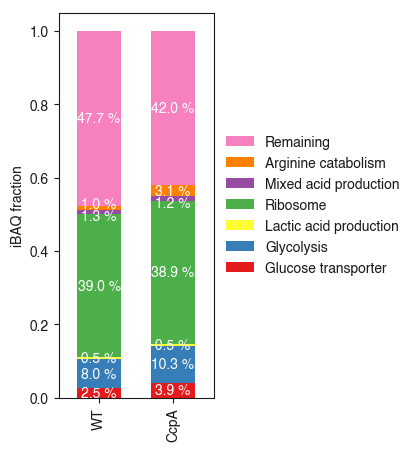

In [53]:
# Create figure of iBAQ fractions per group

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,5))

from itertools import cycle, islice
color = list(islice(cycle(
    [(228./255,26./255,28./255), (55./255,126./255,184./255), (255./255,255./255,51./255), (77./255,175./255,74./255), (152./255,75./255,163./255),
    (255./255,127./255,0./255),(247./255,129./255,191./255)]
), None, len(groupdf_iBAQ_average_frac)))

groupdf_iBAQ_average_frac.transpose().loc[["WT", "CcpA"]].plot.bar(stacked=True , ax=ax, width=0.6, colors=color) #, figsize=(10,7))
ax.set_ylabel("iBAQ fraction") 
handles, labels = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
for i in range(len(labels)):
    if '_' in labels[i]:
        labels[i] = labels[i].replace("_", " ")
labels = ['Glucose transporter', 'Glycolysis', 'Lactic acid production', 'Ribosome', 'Mixed acid production',
         'Arginine catabolism', 'Remaining']

#ax.legend(handles, labels) #, fontsize=9)
#ax.legend().set_visible(False)
legend = ax.legend(list(reversed(handles)), list(reversed(labels)), loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
#ax = percentage_dist.plot.bar(stacked=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if 0.6 <= height*100 <= 1.2:
        ax.text(x+width/2, 
                y+height+0.005, 
                '{:.1f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center', color='w')
    elif 1.2 <= height*100 <2:
        ax.text(x+width/2, 
                y-0.005, 
                '{:.1f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center', color='w')
    else:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.1f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center', color='w')

figname='iBAQ_fraction_ccpawt_3'
fig.savefig(os.path.join("Figures", figname+'.svg'), dpi=fig.dpi,  bbox_extra_artists=(legend,), bbox_inches='tight')
fig.savefig(os.path.join("Figures", figname+'.pdf'), dpi=fig.dpi,  bbox_extra_artists=(legend,), bbox_inches='tight')
fig.show()

### Membrane checks

Protein iBAQ fraction in transport proteins (proteins assigned as transporters in the model).

In [54]:
print "ccpa:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transport_prots_wd))).sum(axis=0)[ccpa_columns]/data_iBAQ_llmg.sum(axis=0)[ccpa_columns]))
print "wt:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transport_prots_wd))).sum(axis=0)[wt_columns]/data_iBAQ_llmg.sum(axis=0)[wt_columns]))

ccpa: 0.07717270441014257
wt: 0.08520201530273133


Protein iBAQ fraction in transmembrane list (proteins assigned as transmembrane protein according to uniprot, retrieved from preprocessed_data dataframe).

In [55]:
print "ccpa:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transmembrane_list))).sum(axis=0)[ccpa_columns]/data_iBAQ_llmg.sum(axis=0)[ccpa_columns]))
print "wt:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transmembrane_list))).sum(axis=0)[wt_columns]/data_iBAQ_llmg.sum(axis=0)[wt_columns]))

ccpa: 0.032579599157394334
wt: 0.03417384264482814


Protein iBAQ fraction in transport proteins and transmembrane list together

In [56]:
print "ccpa:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transport_prots_wd+transmembrane_list))).sum(axis=0)[ccpa_columns]/data_iBAQ_llmg.sum(axis=0)[ccpa_columns]))
print "wt:", np.mean(list(data_iBAQ_llmg.reindex(list(set(transport_prots_wd+transmembrane_list))).sum(axis=0)[wt_columns]/data_iBAQ_llmg.sum(axis=0)[wt_columns]))

ccpa: 0.09691371808471769
wt: 0.1071025885977946


In [57]:
# fisher exact test on membrane proteins vs rest in ccpa and wt
# select significant changed proteins
# Check:
membrsignif = 0
signifrest = 0
for llmg in interesting.index:
    # if in membrane list: sign membr +1    transmembrane_list
    if llmg in transmembrane_list:
        membrsignif +=1
    else:
        signifrest +=1
# else: sign rest +1
# len membrane list - sign membr
restmembr = len(set(transmembrane_list)) - membrsignif
# len all - membrane list - sign rest
rest = len(iBAQ_frac_llmg) - len(transmembrane_list) - signifrest

print membrsignif
print signifrest
print restmembr
print rest

# Fisher exact test
oddsratio, pvalue = stats.fisher_exact([[11,95],[40,760]])
pvalue

11
40
95
760


0.03943741418251649

In [58]:
# fisher exact test on membrane proteins vs rest in ccpa and wt
# select significant changed proteins
# Check:
membrsignif = 0
signifrest = 0
for llmg in interesting.index:
    # if in membrane list: sign membr +1    transmembrane_list
    if llmg in set(transport_prots_wd + transmembrane_list):
        membrsignif +=1
    else:
        signifrest +=1
# else: sign rest +1
# len membrane list - sign membr
restmembr = len(set(transport_prots_wd + transmembrane_list)) - membrsignif
# len all - membrane list - sign rest
rest = len(iBAQ_frac_llmg) - len(set(transport_prots_wd + transmembrane_list)) - signifrest

print membrsignif
print signifrest
print restmembr
print rest

# Fisher exact test
oddsratio, pvalue = stats.fisher_exact([[14,131],[37,724]])
pvalue

14
37
131
724


0.029511717905305976

In [59]:
# fisher exact test on membrane proteins vs rest in ccpa and wt
# select significant changed proteins
# Check:
membrsignif = 0
signifrest = 0
for llmg in interesting.index:
    # if in membrane list: sign membr +1    transmembrane_list
    if llmg in set(transport_prots_wd):
        membrsignif +=1
    else:
        signifrest +=1
# else: sign rest +1
# len membrane list - sign membr
restmembr = len(set(transport_prots_wd)) - membrsignif
# len all - membrane list - sign rest
rest = len(iBAQ_frac_llmg) - len(set(transport_prots_wd)) - signifrest

print membrsignif
print signifrest
print restmembr
print rest

# Fisher exact test
oddsratio, pvalue = stats.fisher_exact([[8,61],[43,794]])
pvalue

8
43
61
794


0.049073251914988396

<a id='volcano_plots'></a>

## 5. Volcano plot of proteome data CcpA mutant vs. WT
Fold-changes, p-values and significance line were generated with Perseus.

In [60]:
# load the volcano significance line data from perseus
#sigline = pd.read_csv(os.path.join(workbookDir, "data", "CcpA_chemostat", "20190809_perseusprocessed_significant_curve_vulcanoplot.txt"), sep='\t',
#                       na_filter = False, dtype='a')
sigline = pd.read_csv(os.path.join(workbookDir, "data", "CcpA_chemostat", "20191108_perseusprocessed_significant_curve_vulcanoplot.txt"), sep='\t',
                       na_filter = False, dtype='a')
sigline = sigline.drop([0,1], axis=0)
sigline

,x,y
2,30,0.1766417324543
3,29.9899997711182,0.176642745733261
4,29.9799995422363,0.176643759012222
5,29.9699993133545,0.176644787192345
6,29.9599990844727,0.176645800471306
7,29.9500007629395,0.176646813750267
8,29.9400005340576,0.176647841930389
9,29.9300003051758,0.176648855209351
10,29.9200000762939,0.176649883389473
11,29.9099998474121,0.176650896668434


In [61]:
sigline['x'] = sigline['x'].astype(float)
sigline['y'] = sigline['y'].astype(float)

sigline = sigline[sigline['x']<4]
sigline = sigline[sigline['x']>-4]
sigline

,x,y
2603,3.99,0.198957
2604,3.98,0.199030
2605,3.97,0.199103
2606,3.96,0.199176
2607,3.95,0.199250
2608,3.94,0.199324
2609,3.93,0.199399
2610,3.92,0.199474
2611,3.91,0.199550
2612,3.90,0.199626


In [62]:
# Some lists for highlighting in volcano plot
glc = ['llmg_0729','llmg_0727'] #'llmg_0728' is TRANSMEMBRANE (not measured), llmg_0727 also TRANSMEMBRANE
arg = ['llmg_0138','llmg_0139']
arc_genes = [
       'llmg_2307', #arcD2   TRANSMEMBRANE, not measured
       'llmg_2308', #arcT
       'llmg_2309', #arcC2
       'llmg_2310', #arcC1
       'llmg_2311', #arcD1   TRANSMEMBRANE, not measured
       'llmg_2312', #arcB
       'llmg_2313', #arcA
      ]
arc = [i for i in arc_genes if i in data_iBAQ_llmg.index] #2307 and 2311 are transmembrane proteins, but not measured!

# Unused membrane proteins

opp = ['llmg_0701','llmg_0697', 'llmg_0698', 'llmg_0699', 'llmg_0702'] #llmg_0700 is also part of operon, TRANSMEMBRANE, not measured
                                                                       #llmg_0699 TRANSMEMBRANE
tellurium = ['llmg_1350', 'llmg_1351', 'llmg_1352']
nox = ['llmg_1734', 'llmg_1735', 'llmg_1770', 'llmg_0408'] #llmg_1734 is noxB is TRANSMEMBRANE
ptc_cel = ["llmg_0437", "llmg_0438"]


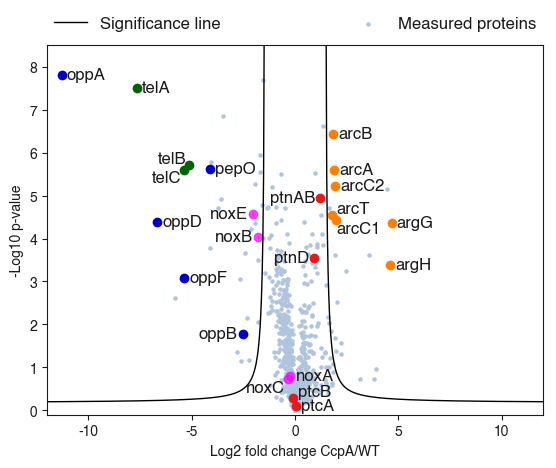

In [63]:
# Interesting ones highlighted
fig, ax = plt.subplots()

from itertools import cycle, islice
color = list(islice(cycle(
    [(228./255,26./255,28./255), (55./255,126./255,184./255), (255./255,255./255,51./255), (77./255,175./255,74./255), (152./255,75./255,163./255),
    (255./255,127./255,0./255),(247./255,129./255,191./255)]
), None, len(groupdf_iBAQ_average_frac)))

# Show the significance line (s0=1, FDR = 0.05)
ax.plot(np.log2(10**(sigline['x'])), sigline['y'], label = 'Significance line', color='black', linewidth=1.)

# Data points
ax.scatter(np.log2(10**(lfq_stats_llmg['fc'])), lfq_stats_llmg['-log p'], 
           label='Measured proteins', alpha=1., color='lightsteelblue',s=5 ) #, c=color, s=scale, label=color, alpha=0.3, edgecolors='none')
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[glc]['fc'])), lfq_stats_llmg.loc[glc]['-log p'], 
           label='glucose ptn mannose', color=(228./255,26./255,28./255))#'dodgerblue') #, marker='^'
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[ptc_cel]['fc'])), lfq_stats_llmg.loc[ptc_cel]['-log p'], 
           label='glucose ptc cellobiose', color=(228./255,26./255,28./255)) #'royalblue') #, marker='^'
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[arg]['fc'])), lfq_stats_llmg.loc[arg]['-log p'], 
           label='arg arginine', color=(255./255,127./255,0./255)) #'limegreen') #, marker = 'o')
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[arc]['fc'])), lfq_stats_llmg.loc[arc]['-log p'], 
           label='arc arginine', color=(255./255,127./255,0./255)) #'darkcyan') #, marker = 'o')

ax.scatter(np.log2(10**(lfq_stats_llmg.loc[opp]['fc'])), lfq_stats_llmg.loc[opp]['-log p'], 
           label='oligopeptide transport', color=(0./255,0./255,205./255)) #, alpha=0.7) #'orangered', alpha = 0.7)
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[tellurium]['fc'])), lfq_stats_llmg.loc[tellurium]['-log p'], 
           label='tellurium resistance', color=(0./255,100./255,0./255))#'indianred', alpha = 0.7)
ax.scatter(np.log2(10**(lfq_stats_llmg.loc[nox]['fc'])), lfq_stats_llmg.loc[nox]['-log p'], 
           label='nox', color='fuchsia', alpha = 0.7)


plt.rc('axes', labelsize=12, titlesize=10) 
#plt.rc('xtick', labelsize=10)

ax.set(xlabel='Log2 fold change CcpA/WT', ylabel='-Log10 p-value', title='')
ax.set_ylim((-0.1,8.5))
ax.set_xlim((-12,12))

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
#ax.grid(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", 
          borderaxespad=0, ncol=2, fontsize=12, frameon=False)

# Label significant model proteins
for i in glc + ptc_cel+arg+arc+opp+tellurium+nox:
    x = np.log2(10**(lfq_stats_llmg.loc[i]['fc']))
    y = lfq_stats_llmg.loc[i]['-log p']
    #ax.scatter(x, y, marker='o', color='fuchsia', s=5, alpha = 0.5)
    name = preprocessed_data[preprocessed_data["Gene names  (ordered locus )"]==i]["Gene names"][0].split(' ')[0]
    if name in ['telC']:
        ax.text(x-0.15, y-0.2, name, horizontalalignment='right', verticalalignment='center', fontsize=12)
    elif name in ['noxC']:
        ax.text(x-0.15, y-0.2, name, horizontalalignment='right', verticalalignment='center', fontsize=12)
    elif name in ['arcC1']:
        ax.text(x, y-0.2, name, horizontalalignment='left', verticalalignment='center', fontsize=12)
    elif name in ['ptcB']:
        ax.text(x+0.25, y+0.15, name, horizontalalignment='left', verticalalignment='center', fontsize=12)
    elif name in ['arcT']:
        ax.text(x+0.2, y+0.15, name, horizontalalignment='left', verticalalignment='center', fontsize=12)
    elif name in ['telB']:
        ax.text(x-0.1, y+0.15, name, horizontalalignment='right', verticalalignment='center', fontsize=12)
    elif name in ['noxE', 'noxB', 'ptnD', 'oppB', 'ptnAB']:
        ax.text(x-0.25, y, name, horizontalalignment='right', verticalalignment='center', fontsize=12)
    else:
        ax.text(x+0.25, y, name, horizontalalignment='left', verticalalignment='center', fontsize=12)

filename = 'volcano_ccpa_wt_interesting_largefont'
plt.savefig('Figures/'+filename+'.png', bbox_inches = 'tight')
plt.savefig('Figures/'+filename+'.pdf', bbox_inches = 'tight')
plt.savefig('Figures/'+filename+'.eps', bbox_inches = 'tight')
plt.savefig('Figures/'+filename+'.svg', bbox_inches = 'tight')


plt.show()



<a id='flux'></a>

# 6. Exchange fluxes

### Import amino acid uptake rate data

In [64]:
aafluxes = pd.read_csv("data\CcpA_chemostat\Fluxdata.txt")
aafluxes

# NOR_Conc is intern standard

,id,strain,reactornum,ALA_Conc,ARG_Conc,ASN_Conc,ASP_Conc,CYS_Conc,GLN_Conc,GLU_Conc,...,LEU_Conc,LYS_Conc,MET_Conc,NOR_Conc,PHE_Conc,SER_Conc,THR_Conc,TRP_Conc,TYR_Conc,VAL_Conc
0,5,ccpa,R1,-0.317641,-0.778894,-0.242649,-0.016349,-0.057732,-0.333289,0.012478,...,-0.306030,-0.222953,-0.078707,0.0,-0.066173,-0.839217,-0.281930,-0.064660,-0.037607,-0.234797
1,6,ccpa,R2,-0.319839,-0.774038,-0.244242,-0.037876,-0.048232,-0.341379,-0.001315,...,-0.301824,-0.234947,-0.079642,0.0,-0.072878,-0.830139,-0.279907,-0.074315,-0.045717,-0.237323
2,7,ccpa,R3,-0.302748,-0.772843,-0.245338,-0.064652,-0.005918,-0.336667,-0.007076,...,-0.291175,-0.230344,-0.074252,0.0,-0.067355,-0.827301,-0.280857,-0.073935,-0.037492,-0.235792
3,8,ccpa,R4,-0.302654,-0.780943,-0.257293,-0.167763,0.236307,-0.357081,-0.047703,...,-0.275602,-0.294124,-0.075959,0.0,-0.069079,-0.824442,-0.300279,-0.070774,-0.036424,-0.256902
4,9,WT,R1,-0.304088,-0.659394,-0.261572,-0.228794,0.504517,-0.394652,-0.040165,...,-0.244085,-0.307123,-0.071523,0.0,-0.084618,-0.886365,-0.318198,-0.067804,-0.049333,-0.270326
5,10,WT,R2,-0.300326,-0.641180,-0.259450,-0.249456,0.513266,-0.390749,-0.055282,...,-0.240889,-0.314742,-0.068005,0.0,-0.091531,-0.876785,-0.330830,-0.076736,-0.049259,-0.275261
6,11,WT,R3,-0.319498,-0.734271,-0.239984,-0.010070,-0.084484,-0.153692,0.083990,...,-0.272582,-0.078815,-0.070983,0.0,-0.071822,-0.952169,-0.181330,-0.086507,-0.047637,-0.211141
7,12,WT,R4,-0.311324,-0.714792,-0.230217,-0.023023,-0.074691,-0.151482,0.074983,...,-0.268404,-0.066414,-0.068640,0.0,-0.072632,-0.926093,-0.174494,-0.081264,-0.046798,-0.211698


In [65]:
# Remove nor column, which is the internal standard
aafluxes.drop(columns=["NOR_Conc"], inplace=True)

# Convert to long format for plotting
aafluxes_long = pd.melt(aafluxes, 
                        id_vars=['id','strain', 'reactornum'], 
                        var_name='amino_acid',
                        value_vars=aafluxes.columns[3:22],
                        value_name='flux')

aafluxes_long #['id','strain', 'reactornum']

,id,strain,reactornum,amino_acid,flux
0,5,ccpa,R1,ALA_Conc,-0.317641
1,6,ccpa,R2,ALA_Conc,-0.319839
2,7,ccpa,R3,ALA_Conc,-0.302748
3,8,ccpa,R4,ALA_Conc,-0.302654
4,9,WT,R1,ALA_Conc,-0.304088
5,10,WT,R2,ALA_Conc,-0.300326
6,11,WT,R3,ALA_Conc,-0.319498
7,12,WT,R4,ALA_Conc,-0.311324
8,5,ccpa,R1,ARG_Conc,-0.778894
9,6,ccpa,R2,ARG_Conc,-0.774038


In [66]:
aafluxes_error = pd.read_csv("data\CcpA_chemostat\Fluxerror.txt")
aafluxes_error

,id,strain,reactornum,ALA_Conc,ARG_Conc,ASN_Conc,ASP_Conc,CYS_Conc,GLN_Conc,GLU_Conc,...,LEU_Conc,LYS_Conc,MET_Conc,NOR_Conc,PHE_Conc,SER_Conc,THR_Conc,TRP_Conc,TYR_Conc,VAL_Conc
0,5,ccpa,R1,0.010077,0.019115,0.009985,0.000855,0.003797,0.012419,0.000546,...,0.008658,0.008295,0.002335,0.0,0.002428,0.027538,0.016445,0.011132,0.002168,0.009753
1,6,ccpa,R2,0.008078,0.015978,0.008304,0.001619,0.004796,0.010645,0.000043,...,0.008570,0.006483,0.002577,0.0,0.001859,0.020186,0.010767,0.012173,0.001224,0.007460
2,7,ccpa,R3,0.016651,0.016813,0.017128,0.004081,0.001077,0.017805,0.000407,...,0.017028,0.013335,0.004942,0.0,0.003789,0.045563,0.023488,0.006103,0.002099,0.014721
3,8,ccpa,R4,0.006190,0.011491,0.007151,0.009626,0.041380,0.089794,0.001633,...,0.008498,0.018823,0.003891,0.0,0.002690,0.035410,0.134327,0.004438,0.001726,0.010541
4,9,WT,R1,0.009102,0.051525,0.010762,0.013378,0.073961,0.010022,0.001704,...,0.011345,0.032783,0.002670,0.0,0.002209,0.033535,0.037768,0.012057,0.001416,0.012536
5,10,WT,R2,0.011848,0.035866,0.012050,0.017140,0.047764,0.019409,0.002908,...,0.003664,0.024840,0.004472,0.0,0.003244,0.016036,0.113185,0.005653,0.001301,0.016413
6,11,WT,R3,0.008516,0.037458,0.006128,0.000245,0.004905,0.004296,0.002038,...,0.007969,0.003929,0.001991,0.0,0.001898,0.027825,0.005438,0.002808,0.001289,0.005702
7,12,WT,R4,0.012051,0.032704,0.006916,0.000558,0.007977,0.006981,0.002063,...,0.012997,0.004244,0.002884,0.0,0.002932,0.042586,0.006205,0.003516,0.001580,0.006260


In [67]:
aaR_EX = [
    "R_EX_ala__D_e", #R_EX_ala__L_e
    "R_EX_arg__L_e",
    "R_EX_asn__L_e",
    "R_EX_asp__L_e",
    "R_EX_cys__L_e",
    "R_EX_gln__L_e",
    "R_EX_glu__L_e",
    "R_EX_gly_e",
    "R_EX_his__L_e",
    "R_EX_ile__L_e",
    "R_EX_leu__L_e",
    "R_EX_lys__L_e",
    "R_EX_met__L_e", #R_EX_met__D_e
    None, #NOR_Conc
    "R_EX_phe__L_e",
    "R_EX_ser__L_e", #R_EX_ser__D_e
    "R_EX_thr__L_e",
    "R_EX_trp__L_e",
    "R_EX_tyr__L_e",
    "R_EX_val__L_e"
]

In [68]:
aafluxmapping = dict()
for i, aa in enumerate(list(aafluxes.columns[3:])):
    aafluxmapping[aa] = aaR_EX[i]
#del(aafluxmapping['NOR_Conc'])
aafluxmapping

{'ALA_Conc': 'R_EX_ala__D_e',
 'ARG_Conc': 'R_EX_arg__L_e',
 'ASN_Conc': 'R_EX_asn__L_e',
 'ASP_Conc': 'R_EX_asp__L_e',
 'CYS_Conc': 'R_EX_cys__L_e',
 'GLN_Conc': 'R_EX_gln__L_e',
 'GLU_Conc': 'R_EX_glu__L_e',
 'GLY_Conc': 'R_EX_gly_e',
 'HIS_Conc': 'R_EX_his__L_e',
 'ISO_Conc': 'R_EX_ile__L_e',
 'LEU_Conc': 'R_EX_leu__L_e',
 'LYS_Conc': 'R_EX_lys__L_e',
 'MET_Conc': 'R_EX_met__L_e',
 'PHE_Conc': None,
 'SER_Conc': 'R_EX_phe__L_e',
 'THR_Conc': 'R_EX_ser__L_e',
 'TRP_Conc': 'R_EX_thr__L_e',
 'TYR_Conc': 'R_EX_trp__L_e',
 'VAL_Conc': 'R_EX_tyr__L_e'}

In [69]:
aafluxmapping2 = {y:x for x,y in aafluxmapping.iteritems()}
aafluxmapping2

{None: 'PHE_Conc',
 'R_EX_ala__D_e': 'ALA_Conc',
 'R_EX_arg__L_e': 'ARG_Conc',
 'R_EX_asn__L_e': 'ASN_Conc',
 'R_EX_asp__L_e': 'ASP_Conc',
 'R_EX_cys__L_e': 'CYS_Conc',
 'R_EX_gln__L_e': 'GLN_Conc',
 'R_EX_glu__L_e': 'GLU_Conc',
 'R_EX_gly_e': 'GLY_Conc',
 'R_EX_his__L_e': 'HIS_Conc',
 'R_EX_ile__L_e': 'ISO_Conc',
 'R_EX_leu__L_e': 'LEU_Conc',
 'R_EX_lys__L_e': 'LYS_Conc',
 'R_EX_met__L_e': 'MET_Conc',
 'R_EX_phe__L_e': 'SER_Conc',
 'R_EX_ser__L_e': 'THR_Conc',
 'R_EX_thr__L_e': 'TRP_Conc',
 'R_EX_trp__L_e': 'TYR_Conc',
 'R_EX_tyr__L_e': 'VAL_Conc'}

In [70]:
# Caluculate averages for aa fluxes and errors
aa_means = pd.DataFrame(columns = ["ccpa", "wt"])
aa_errors = pd.DataFrame(columns = ["ccpa", "wt"])
aafluxes_grouped = aafluxes.groupby("strain")
aa_means["ccpa"] = aafluxes_grouped.get_group("ccpa").iloc[:,1:].mean()
aa_means["wt"] = aafluxes_grouped.get_group("WT").iloc[:,1:].mean()

aa_errors['ccpa'] = aafluxes_grouped.get_group("ccpa").iloc[:,1:].std()
aa_errors['wt'] = aafluxes_grouped.get_group("WT").iloc[:,1:].std()

In [71]:
aa_means

,ccpa,wt
ALA_Conc,-0.310720,-0.308809
ARG_Conc,-0.776680,-0.687409
ASN_Conc,-0.247380,-0.247806
ASP_Conc,-0.071660,-0.127836
CYS_Conc,0.031106,0.214652
GLN_Conc,-0.342104,-0.272644
GLU_Conc,-0.010904,0.015882
GLY_Conc,-0.063561,-0.087996
HIS_Conc,-0.002374,0.006781
ISO_Conc,-0.268178,-0.269981


In [72]:
#aa_means.to_csv("data/CcpA_chemostat/aa_mean_fluxes.txt")
#aa_errors.to_csv("data/CcpA_chemostat/aa_stdev.txt")

### Amino acid residual concentrations

In [73]:
aa_residuals = pd.read_csv("data/CcpA_chemostat/AA_residual_conc.txt")
aa_residuals

,id,strain,reactornum,ASP_Conc,GLU_Conc,ASN_Conc,SER_Conc,GLN_Conc,HIS_Conc,GLY_Conc,...,TYR_Conc,CYS_Conc,VAL_Conc,MET_Conc,NOR_Conc,TRP_Conc,PHE_Conc,ISO_Conc,LEU_Conc,LYS_Conc
0,5,ccpa,R1,0.999900,0.679340,0.169140,0.127520,0.059940,0.102600,0.22238,...,0.208320,0.243480,0.311860,0.113160,0.0,0.060020,0.268400,0.140040,0.341660,0.622860
1,6,ccpa,R2,0.960760,0.654520,0.163520,0.134480,0.041540,0.101340,0.22204,...,0.193220,0.260020,0.304640,0.110580,0.0,0.041820,0.255520,0.142380,0.345820,0.598640
2,7,ccpa,R3,0.912125,0.644075,0.160850,0.137300,0.049125,0.128425,0.25260,...,0.208000,0.336575,0.306750,0.120125,0.0,0.042300,0.265325,0.139200,0.364275,0.606325
3,8,ccpa,R4,0.728400,0.571340,0.144020,0.157980,0.018840,0.268520,0.38890,...,0.210620,0.771140,0.273320,0.118460,0.0,0.049360,0.263500,0.144180,0.397680,0.496260
4,9,WT,R1,0.661217,0.592283,0.184683,0.210717,0.024383,0.271817,0.40825,...,0.196583,1.158967,0.299200,0.139633,0.0,0.067217,0.251267,0.169633,0.499317,0.529700
5,10,WT,R2,0.624083,0.567100,0.184050,0.212450,0.024567,0.220883,0.43610,...,0.195933,1.181050,0.286967,0.144233,0.0,0.051650,0.238717,0.156050,0.500700,0.512533
6,11,WT,R3,1.013700,0.787017,0.233717,0.161600,0.421200,0.086133,0.07560,...,0.202150,0.216417,0.407000,0.144733,0.0,0.042283,0.276133,0.221767,0.469717,0.901700
7,12,WT,R4,0.992583,0.776483,0.238350,0.159767,0.417717,0.087467,0.07415,...,0.201317,0.228183,0.396483,0.145233,0.0,0.046700,0.271567,0.230050,0.463950,0.917883


In [74]:
# Remove nor column, which is the internal standard
aa_residuals.drop(columns=["NOR_Conc"], inplace=True)

# Convert to long format for plotting
aa_residuals_long = pd.melt(aa_residuals, 
                            id_vars=['id','strain', 'reactornum'], 
                            var_name='amino_acid',
                            value_vars=aa_residuals.columns[3:22],
                            value_name='concentration')
aa_residuals_long #['id','strain', 'reactornum']

,id,strain,reactornum,amino_acid,concentration
0,5,ccpa,R1,ASP_Conc,0.999900
1,6,ccpa,R2,ASP_Conc,0.960760
2,7,ccpa,R3,ASP_Conc,0.912125
3,8,ccpa,R4,ASP_Conc,0.728400
4,9,WT,R1,ASP_Conc,0.661217
5,10,WT,R2,ASP_Conc,0.624083
6,11,WT,R3,ASP_Conc,1.013700
7,12,WT,R4,ASP_Conc,0.992583
8,5,ccpa,R1,GLU_Conc,0.679340
9,6,ccpa,R2,GLU_Conc,0.654520


In [75]:
aa_residuals_sem = pd.read_csv("data/CcpA_chemostat/AA_residual_conc_sem.txt")
aa_residuals_sem

,id,strain,reactornum,ASP_Conc,GLU_Conc,ASN_Conc,SER_Conc,GLN_Conc,HIS_Conc,GLY_Conc,...,TYR_Conc,CYS_Conc,VAL_Conc,MET_Conc,NOR_Conc,TRP_Conc,PHE_Conc,ISO_Conc,LEU_Conc,LYS_Conc
0,5,ccpa,R1,0.046196,0.024624,0.005587,0.002778,0.001681,0.003601,0.004352,...,0.010865,0.014857,0.010452,0.001886,0.0,0.010228,0.007323,0.003246,0.004809,0.017419
1,6,ccpa,R2,0.035971,0.016879,0.004417,0.001728,0.000971,0.004624,0.011367,...,0.003297,0.025294,0.007222,0.002756,0.0,0.006795,0.003828,0.002900,0.006742,0.010961
2,7,ccpa,R3,0.054048,0.034319,0.010671,0.006947,0.002368,0.020132,0.024488,...,0.010728,0.060808,0.017951,0.007556,0.0,0.003368,0.013764,0.008028,0.019774,0.032528
3,8,ccpa,R4,0.040397,0.017662,0.003396,0.006375,0.004730,0.041467,0.034605,...,0.009489,0.134559,0.010469,0.005812,0.0,0.003009,0.009499,0.010159,0.010775,0.030908
4,9,WT,R1,0.038326,0.024715,0.007465,0.007806,0.000590,0.036326,0.032718,...,0.005436,0.169667,0.013683,0.005100,0.0,0.011942,0.006268,0.005744,0.022889,0.056394
5,10,WT,R2,0.042569,0.029463,0.008412,0.003466,0.001203,0.024227,0.013816,...,0.004916,0.109474,0.016946,0.009410,0.0,0.003781,0.008228,0.008802,0.006395,0.040227
6,11,WT,R3,0.018830,0.014523,0.004697,0.003978,0.009726,0.002510,0.001591,...,0.004449,0.012094,0.008927,0.003359,0.0,0.001200,0.005859,0.004772,0.011568,0.042650
7,12,WT,R4,0.022077,0.020024,0.006785,0.007185,0.018828,0.004874,0.002292,...,0.006518,0.024272,0.011089,0.005941,0.0,0.001970,0.010647,0.006384,0.022020,0.057993


In [76]:
# Caluculate averages for aa fluxes and errors
aa_residuals_mean = pd.DataFrame(columns = ["ccpa", "wt"])
aa_residual_errors = pd.DataFrame(columns = ["ccpa", "wt"])
aa_residuals_grouped = aa_residuals.groupby("strain")
aa_residuals_mean["ccpa"] = aa_residuals_grouped.get_group("ccpa").iloc[:,1:].mean()
aa_residuals_mean["wt"] = aa_residuals_grouped.get_group("WT").iloc[:,1:].mean()

aa_residual_errors['ccpa'] = aa_residuals_grouped.get_group("ccpa").iloc[:,1:].std()
aa_residual_errors['wt'] = aa_residuals_grouped.get_group("WT").iloc[:,1:].std()

In [77]:
aa_residuals_mean


,ccpa,wt
ASP_Conc,0.900296,0.822896
GLU_Conc,0.637319,0.680721
ASN_Conc,0.159382,0.210200
SER_Conc,0.139320,0.186133
GLN_Conc,0.042361,0.221967
HIS_Conc,0.150221,0.166575
GLY_Conc,0.271480,0.248525
THR_Conc,0.055619,0.168771
ARG_Conc,0.000000,0.305737
ALA_Conc,0.898815,0.967067


In [78]:
aa_residual_errors

,ccpa,wt
ASP_Conc,0.120090,0.208859
GLU_Conc,0.046406,0.117190
ASN_Conc,0.010809,0.029891
SER_Conc,0.013101,0.029405
GLN_Conc,0.017404,0.228048
HIS_Conc,0.079847,0.094436
GLY_Conc,0.079580,0.200837
THR_Conc,0.015570,0.141871
ARG_Conc,0.000000,0.051172
ALA_Conc,0.017322,0.004241


### Plot uptake rate in WT and CcpA mutant per amino acid

In [79]:
# t-test difference in amino acid residual concentration
for aa in set(aa_residuals_long['amino_acid']):
    print aa
    print scipy.stats.ttest_ind(aa_residuals_grouped.get_group("ccpa")[aa], aa_residuals_grouped.get_group("WT")[aa],equal_var=False)[1]

ALA_Conc
0.0030822701218014598
GLU_Conc
0.5296267822098517
ASN_Conc
0.03583971806102024
PHE_Conc
0.7051750037490923
ISO_Conc
0.06419232041713951
LYS_Conc
0.32125372169219696
LEU_Conc
0.0003868006523852331
GLN_Conc
0.21327551288715457
HIS_Conc
0.8004982751530493
TRP_Conc
0.6225684581881141
CYS_Conc
0.3820335827762104
THR_Conc
0.20889016202491464
TYR_Conc
0.23275791308510504
ASP_Conc
0.5500204202863064
GLY_Conc
0.8422965814200729
VAL_Conc
0.22495532355924855
ARG_Conc
0.0012606126104459216
MET_Conc
0.000148955042735196
SER_Conc
0.04189029484342711


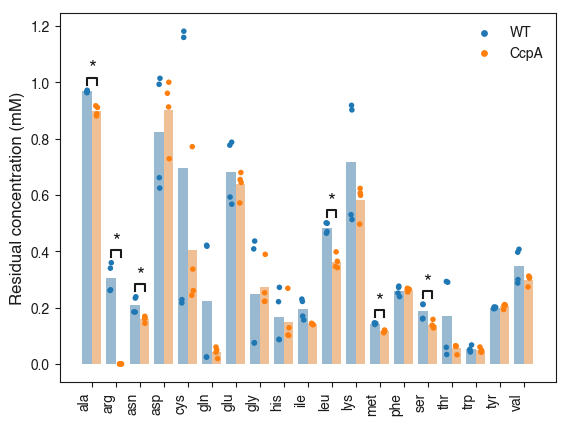

In [80]:
ax = sns.barplot(data=aa_residuals_long, hue='strain', x='amino_acid', y='concentration', capsize=.1, ci=None, order=aafluxes.columns[3:22], alpha=.5, hue_order=["WT", "ccpa"])
sns.stripplot(data=aa_residuals_long, hue='strain', x='amino_acid', y='concentration', dodge=True, alpha=1., size=4., order=aafluxes.columns[3:22], hue_order=["WT", "ccpa"])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [item[0:3].lower() for item in labels]
labels[9] = 'ile' #was iso

ax.set_xticklabels(labels)
ax.set_xlabel("")
ax.set_ylabel("Residual concentration (mM)")

handles, labels = ax.get_legend_handles_labels()
labels[1] = 'CcpA'
labels[3] = 'CcpA'

ax.legend(handles[0:2], labels[0:2], markerscale=0.5, frameon=False) 
          
# statistical annotation; independent t-test, equal variance, p < 0.05

fontsizetext = 15

# ala
x1, x2 = 0, 0   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='ALA_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# arg
x1, x2 = 1, 1   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='ARG_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# asn
x1, x2 = 2, 2   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='ASN_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# leu
x1, x2 = 10, 10   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='LEU_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# met
x1, x2 = 12, 12   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='MET_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

#ser
x1, x2 = 14, 14   
y, h, col = aa_residuals_long[aa_residuals_long['amino_acid']=='SER_Conc']['concentration'].max()+0.02, 0.025, 'k'
#y=0.05
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext) 


plt.savefig("Figures/aa_residuals_barplot.svg")
plt.savefig("Figures/aa_residuals_barplot.eps")
plt.savefig("Figures/aa_residuals_barplot.pdf")
plt.savefig("Figures/aa_residuals_barplot.png")

plt.show()

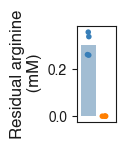

In [81]:
fig, ax = plt.subplots(figsize=(0.5,1.25))
ax = sns.barplot(data=aa_residuals_long[aa_residuals_long['amino_acid']=='ARG_Conc'], hue='strain', x='amino_acid', y='concentration', capsize=.1, ci=None,  alpha=.5, hue_order=["WT", "ccpa"], palette=[(55./255,126./255,184./255,1.),(255./255,127./255,0./255,1.)])
sns.stripplot(data=aa_residuals_long[aa_residuals_long['amino_acid']=='ARG_Conc'], hue='strain', x='amino_acid', y='concentration', dodge=True, alpha=1., size=4., hue_order=["WT", "ccpa"], palette=[(55./255,126./255,184./255,1.),(255./255,127./255,0./255,1.)])

ax.set_xticklabels([''])
ax.set_xticks([], [])

ax.set_xlabel("")

ax.set_ylabel("Residual arginine\n (mM)")

handles, labels = ax.get_legend_handles_labels()
labels[1] = 'CcpA'
labels[3] = 'CcpA'

ax.legend(handles[0:2], labels[0:2], markerscale=0.5, frameon=False) 
ax.legend().set_visible(False)

plt.savefig("Figures/arg_residuals_barplot.svg")
plt.savefig("Figures/arg_residuals_barplot.eps")
plt.savefig("Figures/arg_residuals_barplot.pdf")
plt.savefig("Figures/arg_residuals_barplot.png")

plt.show()

In [82]:
# t-test difference in amino acid flux 
for aa in set(aafluxes_long['amino_acid']):
    print aa
    print scipy.stats.ttest_ind(aafluxes_grouped.get_group("ccpa")[aa], aafluxes_grouped.get_group("WT")[aa],equal_var=False)[1]

ALA_Conc
0.7715427594874938
GLU_Conc
0.5335230888097345
ASN_Conc
0.9615956057657854
PHE_Conc
0.09584637371124727
ISO_Conc
0.863686321091866
LYS_Conc
0.49716113784219984
LEU_Conc
0.013463490569194428
GLN_Conc
0.39060160161748597
HIS_Conc
0.8134825220270895
TRP_Conc
0.1798096365378573
CYS_Conc
0.3741622771371951
THR_Conc
0.47649600166741607
TYR_Conc
0.021027681606539454
ASP_Conc
0.47786284634383275
GLY_Conc
0.7366653246205856
VAL_Conc
0.9637336593781908
ARG_Conc
0.02684132353693336
MET_Conc
0.0038294485572382517
SER_Conc
0.017987602019777123


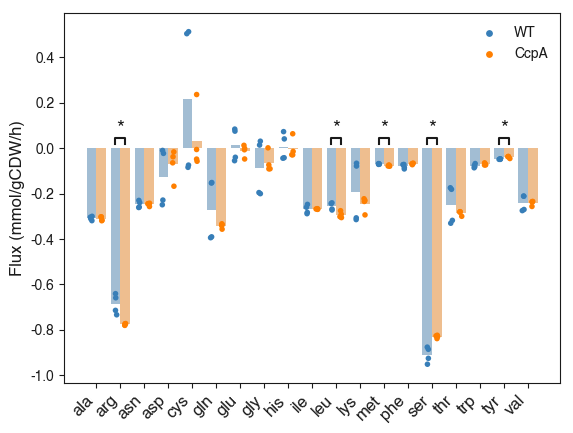

In [83]:
ax = sns.barplot(data=aafluxes_long, hue='strain', x='amino_acid', y='flux', capsize=.1, ci=None, order=aafluxes.columns[3:22], alpha=.5, hue_order=["WT", "ccpa"], palette=[(55./255,126./255,184./255,1.),(255./255,127./255,0./255,1.)])
sns.stripplot(data=aafluxes_long, hue='strain', x='amino_acid', y='flux', dodge=True, alpha=1., size=4., order=aafluxes.columns[3:22], hue_order=["WT", "ccpa"], palette=[(55./255,126./255,184./255,1.),(255./255,127./255,0./255,1.)])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [item[0:3].lower() for item in labels]
labels[9] = 'ile' #was iso

ax.set_xticklabels(labels)
ax.set_xlabel("")
ax.set_ylabel("Flux (mmol/gCDW/h)")

handles, labels = ax.get_legend_handles_labels()
labels[1] = 'CcpA'
labels[3] = 'CcpA'

ax.legend(handles[0:2], labels[0:2], markerscale=0.5, frameon=False) 

# statistical annotation; independent t-test, equal variance, p < 0.05

fontsizetext = 15

# arg
x1, x2 = 1, 1   
y, h, col = aafluxes_long['flux'].max(), 0.025, 'k'
y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# tyr
x1, x2 = 17, 17   
y, h, col = aafluxes_long['flux'].max(), 0.025, 'k'
y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# leu
x1, x2 = 10, 10   
y, h, col = aafluxes_long['flux'].max(), 0.025, 'k'
y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# met
x1, x2 = 12, 12   
y, h, col = aafluxes_long['flux'].max(), 0.025, 'k'
y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

#ser
x1, x2 = 14, 14   
y, h, col = aafluxes_long['flux'].max(), 0.025, 'k'
y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y +h, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)
           
plt.savefig("Figures/aa_fluxes_barplot.svg")
plt.savefig("Figures/aa_fluxes_barplot.eps")
plt.savefig("Figures/aa_fluxes_barplot.pdf")
plt.savefig("Figures/aa_fluxes_barplot.svg")

plt.show()

In [84]:
# Organic acid fluxes
oafluxes = pd.read_csv("data/CcpA_chemostat/2018_05chemostats_wtccpa_fluxdata_organic_acids.txt", sep='\t')
oafluxes

,strain,reactor,Acetate,Arabinose,Ethanol,Glucose,Lactate,Pyruvate,Succinate,Formate,unit
0,WT,R1,2.386709,0.0,5.025169,-16.277510,25.196991,0.054782,0.022265,5.439403,mmol/gDW/h
1,WT,R2,2.448445,0.0,5.833607,-15.912156,24.436461,0.050313,0.023790,5.574549,mmol/gDW/h
2,WT,R3,2.420291,0.0,5.692875,-16.351165,25.346896,0.006554,0.021950,5.252737,mmol/gDW/h
3,WT,R4,2.322344,0.0,6.259597,-16.488126,24.108254,0.006609,0.023183,4.935570,mmol/gDW/h
4,ccpa,R1,2.806199,0.0,4.880751,-16.145828,23.035873,0.108878,0.017264,6.277405,mmol/gDW/h
5,ccpa,R2,3.477015,0.0,7.028267,-15.755452,20.437781,0.113995,0.018644,8.076796,mmol/gDW/h
6,ccpa,R3,3.182457,0.0,7.182044,-15.761175,19.905920,0.106734,0.021234,7.436295,mmol/gDW/h
7,ccpa,R4,2.820720,0.0,6.154667,-15.768271,21.565950,0.097452,0.022930,6.746462,mmol/gDW/h


In [85]:
# Remove nor column, which is the internal standard
oafluxes.drop(columns=["Arabinose"], inplace=True)
oafluxes

,strain,reactor,Acetate,Ethanol,Glucose,Lactate,Pyruvate,Succinate,Formate,unit
0,WT,R1,2.386709,5.025169,-16.277510,25.196991,0.054782,0.022265,5.439403,mmol/gDW/h
1,WT,R2,2.448445,5.833607,-15.912156,24.436461,0.050313,0.023790,5.574549,mmol/gDW/h
2,WT,R3,2.420291,5.692875,-16.351165,25.346896,0.006554,0.021950,5.252737,mmol/gDW/h
3,WT,R4,2.322344,6.259597,-16.488126,24.108254,0.006609,0.023183,4.935570,mmol/gDW/h
4,ccpa,R1,2.806199,4.880751,-16.145828,23.035873,0.108878,0.017264,6.277405,mmol/gDW/h
5,ccpa,R2,3.477015,7.028267,-15.755452,20.437781,0.113995,0.018644,8.076796,mmol/gDW/h
6,ccpa,R3,3.182457,7.182044,-15.761175,19.905920,0.106734,0.021234,7.436295,mmol/gDW/h
7,ccpa,R4,2.820720,6.154667,-15.768271,21.565950,0.097452,0.022930,6.746462,mmol/gDW/h


In [86]:
oafluxes = oafluxes.reset_index()
oafluxes

,index,strain,reactor,Acetate,Ethanol,Glucose,Lactate,Pyruvate,Succinate,Formate,unit
0,0,WT,R1,2.386709,5.025169,-16.277510,25.196991,0.054782,0.022265,5.439403,mmol/gDW/h
1,1,WT,R2,2.448445,5.833607,-15.912156,24.436461,0.050313,0.023790,5.574549,mmol/gDW/h
2,2,WT,R3,2.420291,5.692875,-16.351165,25.346896,0.006554,0.021950,5.252737,mmol/gDW/h
3,3,WT,R4,2.322344,6.259597,-16.488126,24.108254,0.006609,0.023183,4.935570,mmol/gDW/h
4,4,ccpa,R1,2.806199,4.880751,-16.145828,23.035873,0.108878,0.017264,6.277405,mmol/gDW/h
5,5,ccpa,R2,3.477015,7.028267,-15.755452,20.437781,0.113995,0.018644,8.076796,mmol/gDW/h
6,6,ccpa,R3,3.182457,7.182044,-15.761175,19.905920,0.106734,0.021234,7.436295,mmol/gDW/h
7,7,ccpa,R4,2.820720,6.154667,-15.768271,21.565950,0.097452,0.022930,6.746462,mmol/gDW/h


In [87]:
# Convert to long format for plotting
oafluxes_long = pd.melt(oafluxes, 
                            id_vars=['strain', 'reactor'], 
                            var_name='metabolite',
                            value_vars=oafluxes.columns[3:10],
                            value_name='flux')
oafluxes_long

,strain,reactor,metabolite,flux
0,WT,R1,Acetate,2.386709
1,WT,R2,Acetate,2.448445
2,WT,R3,Acetate,2.420291
3,WT,R4,Acetate,2.322344
4,ccpa,R1,Acetate,2.806199
5,ccpa,R2,Acetate,3.477015
6,ccpa,R3,Acetate,3.182457
7,ccpa,R4,Acetate,2.820720
8,WT,R1,Ethanol,5.025169
9,WT,R2,Ethanol,5.833607


In [88]:
# Caluculate averages for oa fluxes and errors
oa_means = pd.DataFrame(columns = ["ccpa", "wt"])
oa_errors = pd.DataFrame(columns = ["ccpa", "wt"])
oafluxes_grouped = oafluxes.groupby("strain")
oa_means["ccpa"] = oafluxes_grouped.get_group("ccpa").iloc[:,1:].mean()
oa_means["wt"] = oafluxes_grouped.get_group("WT").iloc[:,1:].mean()

oa_errors['ccpa'] = oafluxes_grouped.get_group("ccpa").iloc[:,1:].std()
oa_errors['wt'] = oafluxes_grouped.get_group("WT").iloc[:,1:].std()

In [89]:
oa_means

,ccpa,wt
Acetate,3.071598,2.394447
Ethanol,6.311432,5.702812
Glucose,-15.857681,-16.257239
Lactate,21.236381,24.772150
Pyruvate,0.106765,0.029564
Succinate,0.020018,0.022797
Formate,7.134239,5.300565


In [90]:
oa_errors

,ccpa,wt
Acetate,0.321470,0.054291
Ethanol,1.055658,0.511994
Glucose,0.192169,0.246051
Lactate,1.385000,0.595614
Pyruvate,0.006915,0.026602
Succinate,0.002545,0.000844
Formate,0.788287,0.276798


In [91]:
# t-test difference in external metabolite flux 
for aa in set(oafluxes_long['metabolite']):
    print aa
    print scipy.stats.ttest_ind(oafluxes_grouped.get_group("ccpa")[aa], oafluxes_grouped.get_group("WT")[aa],equal_var=True)[1]

Formate
0.0046202046094675235
Pyruvate
0.0013588515186135945
Acetate
0.005984212165984262
Ethanol
0.33950296665614504
Lactate
0.0033592188017089724
Succinate
0.08356783152989045
Glucose
0.042931351524388116


In [92]:
# t-test difference in external metabolite flux 
for aa in set(oafluxes_long['metabolite']):
    print aa
    print scipy.stats.ttest_ind(oafluxes_grouped.get_group("ccpa")[aa], oafluxes_grouped.get_group("WT")[aa],equal_var=False)[1]

Formate
0.013767209630600607
Pyruvate
0.007883881960291399
Acetate
0.022749813346976316
Ethanol
0.35385113974194665
Lactate
0.008972082546746689
Succinate
0.11353017571871575
Glucose
0.0451761230753081


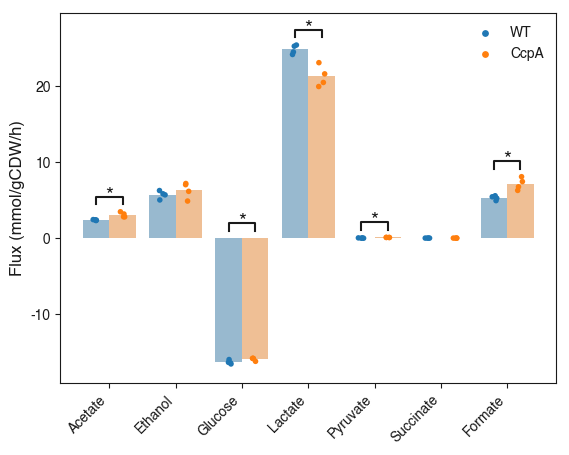

In [93]:
oafluxes_long

ax = sns.barplot(data=oafluxes_long, hue='strain', x='metabolite', y='flux', capsize=.1, ci=None, alpha=.5)
sns.stripplot(data=oafluxes_long, hue='strain', x='metabolite', y='flux', dodge=True, alpha=1., size=4.)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels = [item[0:3].lower() for item in labels]
#labels[9] = 'ile' #was iso

#ax.set_xticklabels(labels)
ax.set_xlabel("")
ax.set_ylabel("Flux (mmol/gCDW/h)")

handles, labels = ax.get_legend_handles_labels()
labels[1] = 'CcpA'

ax.legend(handles[0:2], labels[0:2], markerscale=0.5, frameon=False)
           
# statistical annotation; independent t-test, equal variance, p < 0.05

fontsizetext = 15

# ace
x1, x2 = 0, 0
y, h, col = oafluxes_long[oafluxes_long['metabolite']=='Acetate']['flux'].max()+1., 1., 'k'
#y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y , "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# glc
x1, x2 = 2, 2
y, h, col = 0.+1., 1., 'k'
#y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y , "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# lac
x1, x2 = 3, 3
y, h, col = oafluxes_long[oafluxes_long['metabolite']=='Lactate']['flux'].max()+1., 1., 'k'
#y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y , "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# pyr
x1, x2 = 4, 4
y, h, col = oafluxes_long[oafluxes_long['metabolite']=='Pyruvate']['flux'].max()+1., 1., 'k'
#y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y , "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

# for
x1, x2 = 6, 6
y, h, col = oafluxes_long[oafluxes_long['metabolite']=='Formate']['flux'].max()+1., 1., 'k'
#y=0.02
plt.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontsize=fontsizetext)

plt.savefig("Figures/oafluxes_barplot.svg", bbox_inches = 'tight')
plt.savefig("Figures/oafluxes_barplot.eps", bbox_inches = 'tight')
plt.savefig("Figures/oafluxes_barplot.png", bbox_inches = 'tight')
plt.savefig("Figures/oafluxes_barplot.pdf", bbox_inches = 'tight')

plt.show()

<a id='pca'></a>

# 7. Principal Component analysis 

In [94]:
# Select LFQ data
#LFQ data is already log10 transformed, so no standardization step is done in the following
data_LFQ = preprocessed_data[LFQ_columns] 
data_LFQ.head()

,LFQ intensity BvO325_ccpa_MG1363_1,LFQ intensity BvO326_ccpa_MG1363_2,LFQ intensity BvO327_ccpa_MG1363_3,LFQ intensity BvO328_ccpa_MG1363_4,LFQ intensity BvO329_wt_MG1363_1,LFQ intensity BvO330_wt_MG1363_2,LFQ intensity BvO331_wt_MG1363_3,LFQ intensity BvO332_wt_MG1363_4
Majority protein IDs,,,,,,,,
A2RH74,7.10085296630859,7.24870872497559,7.14429378509521,7.12968969345093,7.30323934555054,7.25556182861328,7.28990077972412,7.30323934555054
A2RH77,6.71917390823364,6.74067831039429,6.78864192962646,6.8233437538147,6.82106113433838,6.78719806671143,6.7553334236145,6.92593574523926
A2RH80,8.33607959747314,8.33189296722412,8.33817768096924,8.37763404846191,8.35715293884277,8.41195583343506,8.30541610717773,8.27216625213623
A2RH85,6.60785150527954,6.4954195022583,6.38399457931519,6.56883525848389,6.69289064407349,6.35147190093994,6.39392614364624,6.67344856262207
A2RH86,6.63816976547241,6.88871288299561,6.7448091506958,6.7226505279541,7.00509452819824,6.90873146057129,6.65474414825439,6.8839225769043


In [95]:
# Select features
features = list(data_LFQ.index)
#print features

# Select data
x = data_LFQ.transpose().loc[:, features].values
#print x

# Seperate target values
y = ['ccpa', 'ccpa', 'ccpa', 'ccpa', 'WT', 'WT', 'WT', 'WT']


In [96]:
# Do PCA
pca = PCA()#n_components=4)
principalComponents = pca.fit_transform(x)

principalDF = pd.DataFrame(data=principalComponents) #, columns=['PC1', 'PC2'])
print principalDF

principalDF['strain'] = y #pd.concat([principalDF, y], axis=1)
finalDF = principalDF.copy()
finalDF

          0         1         2         3         4         5         6  \
0 -4.649852 -0.525040  1.074351  1.107646 -0.961320  2.181881 -0.729915   
1 -4.751315  0.117532  0.108498  0.448772  0.026442 -0.286397  2.424225   
2 -4.634163  0.591953 -0.781009 -1.213204 -2.069105 -1.541414 -0.901756   
3 -4.176695  0.747103 -0.879369 -0.521916  3.071853 -0.166301 -0.804067   
4  4.752826 -0.007721 -2.689083  2.902657 -0.208531 -0.375219 -0.202101   
5  5.012296 -1.694012 -1.894195 -2.663291 -0.225683  1.069349  0.419229   
6  3.145881 -3.909494  2.938802  0.299033  0.428016 -0.949046 -0.248824   
7  5.301021  4.679680  2.122005 -0.359697 -0.061673  0.067147  0.043209   

              7  
0  2.061800e-14  
1  2.061800e-14  
2  2.061800e-14  
3  2.061800e-14  
4  2.061800e-14  
5  2.061800e-14  
6  2.061800e-14  
7  2.061800e-14  


,0,1,2,3,4,5,6,7,strain
0,-4.649852,-0.525040,1.074351,1.107646,-0.961320,2.181881,-0.729915,2.061800e-14,ccpa
1,-4.751315,0.117532,0.108498,0.448772,0.026442,-0.286397,2.424225,2.061800e-14,ccpa
2,-4.634163,0.591953,-0.781009,-1.213204,-2.069105,-1.541414,-0.901756,2.061800e-14,ccpa
3,-4.176695,0.747103,-0.879369,-0.521916,3.071853,-0.166301,-0.804067,2.061800e-14,ccpa
4,4.752826,-0.007721,-2.689083,2.902657,-0.208531,-0.375219,-0.202101,2.061800e-14,WT
5,5.012296,-1.694012,-1.894195,-2.663291,-0.225683,1.069349,0.419229,2.061800e-14,WT
6,3.145881,-3.909494,2.938802,0.299033,0.428016,-0.949046,-0.248824,2.061800e-14,WT
7,5.301021,4.679680,2.122005,-0.359697,-0.061673,0.067147,0.043209,2.061800e-14,WT


In [97]:
# Principal components percentage of explanation of data
pca.explained_variance_ratio_

array([5.86193062e-01, 1.43231568e-01, 9.20397706e-02, 6.56582809e-02,
       5.18176976e-02, 3.27624570e-02, 2.82971641e-02, 1.18081997e-29])

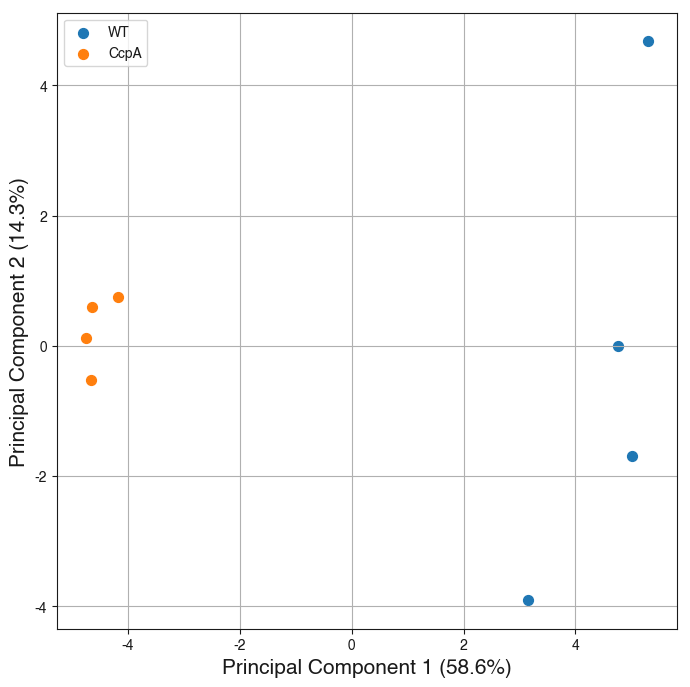

In [98]:
# PCA figure of LFQ data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1' + ' (' + str(round(pca.explained_variance_ratio_[0]*100, 1)) + '%)', fontsize = 15)
ax.set_ylabel('Principal Component 2' + ' (' + str(round(pca.explained_variance_ratio_[1]*100, 1)) + '%)', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
strains = ['WT', 'ccpa']
#colors = ['r', 'b']
#for strain, color in zip(strains,colors):
for strain in strains:
    indicesToKeep = finalDF['strain'] == strain
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 1]
               #, c = color
               , s = 50)
ax.legend(["WT", "CcpA"])
ax.grid()

fig.savefig('Figures/pca_LFQdata.svg')